<a href="https://colab.research.google.com/github/iwatadive28/ESC-50-1DCNN/blob/main/ESC_50_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 環境の準備
Google Colabでの設定
Colabを開き、GPUを有効にします。
メニューから「ランタイム」 > 「ランタイムのタイプを変更」 > 「ハードウェア アクセラレータ」 > 「GPU」を選択。
必要なライブラリのインストール
以下を実行して、必要なライブラリをインストールします。



In [ ]:
!pip install tensorflow librosa numpy matplotlib

# 2. データセットのダウンロード
ESC-50データセットをダウンロードして解凍します。

In [ ]:
import os
import zipfile
import urllib.request

# ESC-50データセットのダウンロード
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
data_dir = "./ESC-50"
os.makedirs(data_dir, exist_ok=True)

zip_path = os.path.join(data_dir, "ESC-50.zip")
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

# 解凍
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

print("データセットの準備完了！")

データセットの準備完了！


# 3. 前処理
データとラベルの準備
ESC-50フォルダ内の音声ファイルをロードします。
ラベルを抽出し、データを分割します。

In [ ]:
"""
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# メタデータを読み込む
metadata_path = "./ESC-50/ESC-50-master/meta/esc50.csv"
metadata = pd.read_csv(metadata_path)

# パラメータ設定
SAMPLE_RATE = 16000  # サンプリングレート
DURATION = 5         # 音声の長さ（秒）

# 音声データのロード関数
def load_audio(file_path, label, sr=SAMPLE_RATE, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    # 長さを統一（ゼロパディング）
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    return y, label

# データ準備
audio_data = []
labels = []

base_path = "./ESC-50/ESC-50-master/audio/"
for index, row in metadata.iterrows():
    file_path = os.path.join(base_path, row["filename"])
    label = row["category"]
    y, lbl = load_audio(file_path, label)
    audio_data.append(y)
    labels.append(lbl)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.2, random_state=42)
"""

「人の声や行動」とそれ以外に分類

- binary_label = 1: 「人の声や行動」に該当する音声。
  ラベルがhuman_labelsに含まれている場合。
  該当ラベル: 'laughing', 'crying_baby', 'sneezing', 'snoring', 'clapping', 'breathing', 'coughing', 'footsteps'
- binary_label = 0: それ以外。ラベルがhuman_labelsに含まれていない場合。

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# メタデータを読み込む
metadata_path = "./ESC-50/ESC-50-master/meta/esc50.csv"
metadata = pd.read_csv(metadata_path)

# パラメータ設定
SAMPLE_RATE = 16000  # サンプリングレート
DURATION = 5         # 音声の長さ（秒）

# 「人の声や行動」に該当するラベルリスト
human_labels = [
    'laughing', 'crying_baby', 'sneezing', 'snoring', 'clapping', 'breathing', 'coughing', 'footsteps'
]

# 音声データのロード関数
def load_audio(file_path, label, sr=SAMPLE_RATE, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    # 長さを統一（ゼロパディング）
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    # ラベルを二値化
    binary_label = 1 if label in human_labels else 0
    return y, binary_label

# データ準備
audio_data = []
labels = []

base_path = "./ESC-50/ESC-50-master/audio/"
for index, row in metadata.iterrows():
    file_path = os.path.join(base_path, row["filename"])
    label = row["category"]
    y, lbl = load_audio(file_path, label)
    audio_data.append(y)
    labels.append(lbl)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.2, random_state=42)

# 結果確認
print(f"訓練データ: {len(X_train)} サンプル")
print(f"テストデータ: {len(X_test)} サンプル")
print(f"クラス分布 (訓練データ): {np.bincount(y_train)}")  # クラスの分布を確認
print(f"クラス分布 (テストデータ): {np.bincount(y_test)}")


訓練データ: 1600 サンプル
テストデータ: 400 サンプル
クラス分布 (訓練データ): [1343  257]
クラス分布 (テストデータ): [337  63]


# 4. モデル構築
1D-CNNを使用したモデルを構築します。

In [ ]:
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# ラベルをエンコード
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# モデル構築
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(SAMPLE_RATE * DURATION, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 79998, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 39999, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 39997, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19998, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 19996, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,674 (612.01 KB)

 Trainable params: 156,674 (612.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install pydot graphviz

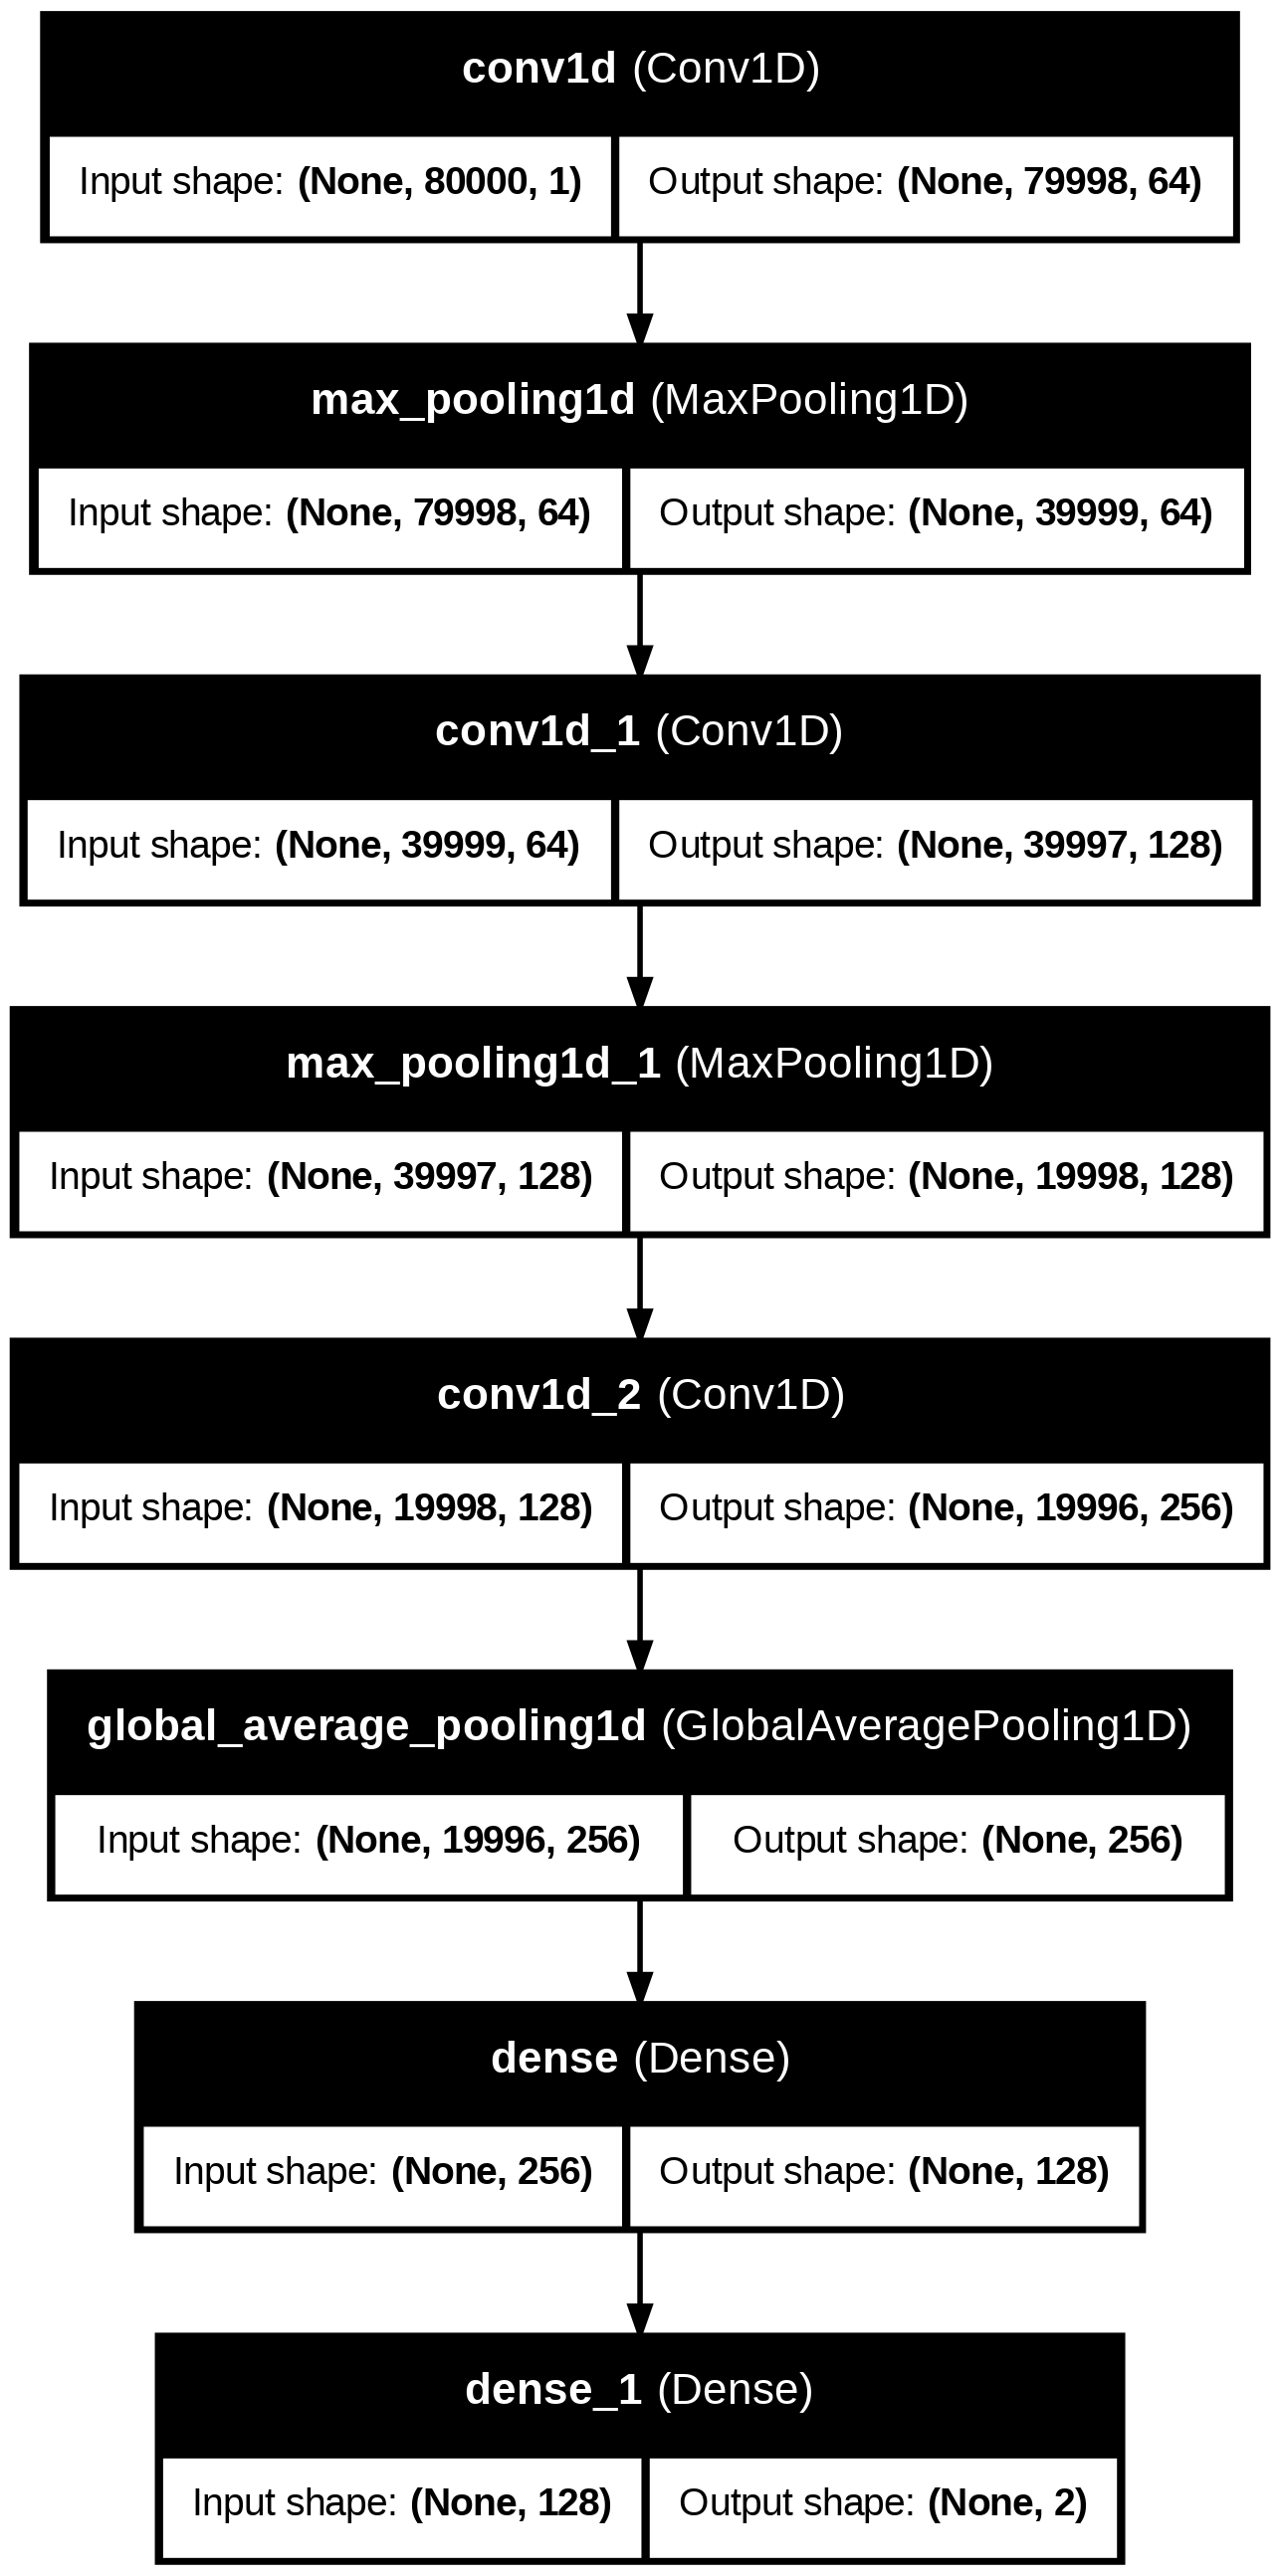

In [ ]:
from tensorflow.keras.utils import plot_model
# モデル構造図の表示
plot_model(
    model,
    to_file="model_structure.png",  # ファイルに保存
    show_shapes=True,  # 入力と出力の形状を表示
    show_layer_names=True  # レイヤー名を表示
)

# Notebook内で画像を表示
from IPython.display import Image
Image("model_structure.png")


# 5. データの準備と訓練
データをモデルに適した形式に変換して訓練します。

X_train shape before reshaping: (1600, 80000, 1)
y_train_enc shape: (1600,)
X_train shape after reshaping: (1600, 80000, 1)
y_train_enc shape: (1600,)
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7764 - loss: 0.5373
Epoch 1: val_loss improved from inf to 0.43022, saving model to trained_1d_cnn_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 583ms/step - accuracy: 0.7774 - loss: 0.5360 - val_accuracy: 0.8425 - val_loss: 0.4302
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8439 - loss: 0.4305
Epoch 2: val_loss improved from 0.43022 to 0.42892, saving model to trained_1d_cnn_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 556ms/step - accuracy: 0.8438 - loss: 0.4307 - val_accuracy: 0.8425 - val_loss: 0.4289
モデルを保存しました: trained_1d_cnn_model.keras


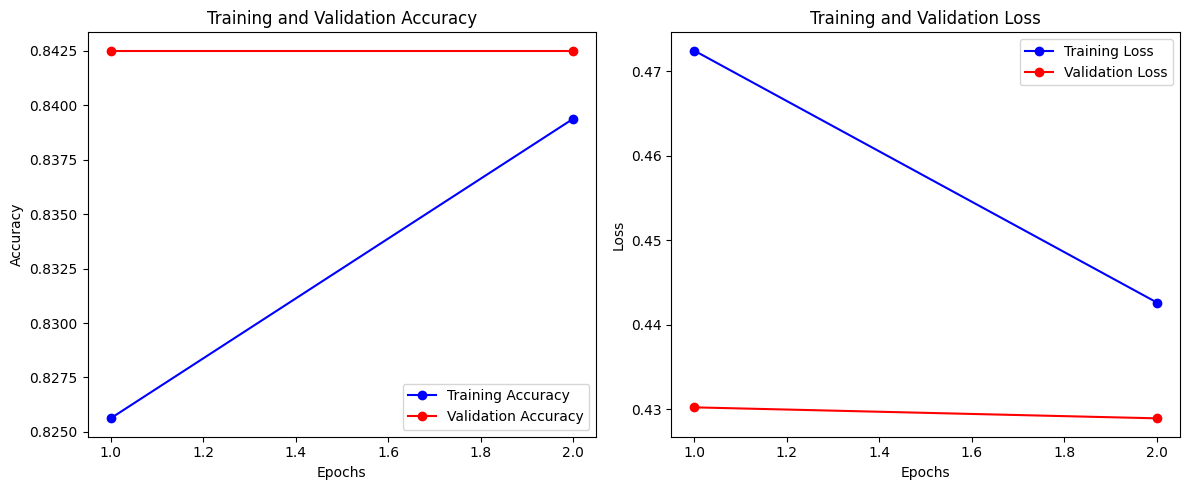

In [ ]:
# データの形状を確認
print(f"X_train shape before reshaping: {np.array(X_train).shape}")
print(f"y_train_enc shape: {np.array(y_train_enc).shape}")

# 入力データの形状を修正
X_train = np.array(X_train).reshape(-1, SAMPLE_RATE * DURATION, 1)
X_test = np.array(X_test).reshape(-1, SAMPLE_RATE * DURATION, 1)

# ラベルをNumPy配列に変換
y_train_enc = np.array(y_train_enc)
y_test_enc = np.array(y_test_enc)

# 修正後の形状を確認
print(f"X_train shape after reshaping: {X_train.shape}")
print(f"y_train_enc shape: {y_train_enc.shape}")

# モデルの保存先パス
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# モデルの訓練時に保存するコールバック
checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,  # 保存先パスを変更
    monitor='val_loss',        # モニタリング対象
    save_best_only=True,       # ベストモデルのみ保存
    verbose=1                  # ログを出力
)

# モデルの訓練
history = model.fit(
    X_train,
    y_train_enc,
    epochs=2, #20
    batch_size=32,
    validation_data=(X_test, y_test_enc),
    callbacks=[checkpoint]  # コールバックを追加
)

# 訓練後、最終モデルを保存
model.save(MODEL_SAVE_PATH)
# `.h5`形式で保存
# model.save("trained_1d_cnn_model.h5", save_format="h5")

print(f"モデルを保存しました: {MODEL_SAVE_PATH}")

# 訓練履歴を可視化
def plot_training_history(history):
    """AccuracyとLossのグラフを表示"""
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracyのプロット
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Lossのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# グラフを表示
plot_training_history(history)

In [48]:
import time
import os
import tensorflow as tf

# モデルの保存先パス
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# モデルサイズの計測
def calculate_model_size(model, save_path=MODEL_SAVE_PATH):
    # model.save(save_path)  # 一時的にモデルを保存
    model_size = os.path.getsize(save_path) / (1024 * 1024)  # サイズをMB単位で計測
    # os.remove(save_path)  # 保存したモデルを削除
    return model_size

# 推論時間の計測
def measure_inference_time(model, sample_input, num_trials=100):
    """
    モデル推論の時間を計測
    - model: 計測するモデル
    - sample_input: モデルへの入力データ
    - num_trials: 推論を繰り返す回数
    """
    # TensorFlowのキャッシュをクリア
    tf.keras.backend.clear_session()

    # 推論の時間を計測
    start_time = time.time()
    for _ in range(num_trials):
        _ = model.predict(sample_input, verbose=0)
    total_time = time.time() - start_time
    avg_time = total_time / num_trials
    return avg_time

# モデルサイズの評価
model_size = calculate_model_size(model)
print(f"モデルサイズ: {model_size:.2f} MB")

# 推論時間の評価
# サンプル入力データの作成（1秒の音声データを想定）
sample_input = tf.random.normal((1, SAMPLE_RATE * DURATION, 1))  # バッチサイズ1の入力
inference_time = measure_inference_time(model, sample_input)
print(f"1サンプルあたりの平均推論時間: {inference_time:.4f} 秒")


モデルサイズ: 1.83 MB
1サンプルあたりの平均推論時間: 0.0639 秒


# 6. モデルの評価
保存形式が.kerasの場合も.h5の場合も、以下の方法でロードできます。
テストデータでモデルの性能を評価します。

In [49]:
from tensorflow.keras.models import load_model

# 保存済みモデルのロード
loaded_model = load_model(MODEL_SAVE_PATH)
print("モデルをロードしました。")
loaded_model.summary()


# テストデータで評価
test_loss, test_acc = model.evaluate(X_test, y_test_enc)
print(f"テストデータの損失: {test_loss}")
print(f"テストデータの精度: {test_acc}")


モデルをロードしました。


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 79998, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 39999, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 39997, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19998, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 19996, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 470,024 (1.79 MB)

 Trainable params: 156,674 (612.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 313,350 (1.20 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8530 - loss: 0.4219
テストデータの損失: 0.42892229557037354
テストデータの精度: 0.8424999713897705


# 7. 推論
新しい音声データをモデルで分類します。

In [50]:
# 推論関数
def predict_audio(file_path):
    y, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    if len(y) < SAMPLE_RATE * DURATION:
        y = np.pad(y, (0, SAMPLE_RATE * DURATION - len(y)))
    y = y.reshape(1, -1, 1)
    predictions = model.predict(y)
    predicted_label = encoder.inverse_transform([np.argmax(predictions)])
    return predicted_label[0]

# 推論例
test_file = "./ESC-50/ESC-50-master/audio/1-100032-A-0.wav"
print(f"推論結果: {predict_audio(test_file)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
推論結果: 0


In [68]:
import random
import os
import pandas as pd

# ディレクトリと設定
AUDIO_DIR = "./ESC-50/ESC-50-master/audio/"  # 音声ファイルのディレクトリ
META_FILE = "./ESC-50/ESC-50-master/meta/esc50.csv"  # メタデータファイル
N = 5  # ランダムに選ぶファイル数

# 音声ファイルのランダム選択とラベルの取得
def list_random_files_with_labels(audio_dir, meta_file, n):
    """指定されたディレクトリからランダムにN個の音声ファイルと対応するラベルをリストアップする"""
    # メタデータの読み込み
    metadata = pd.read_csv(meta_file)

    # 音声ファイルリストの作成
    audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith(".wav")]

    # ランダムに選択
    selected_files = random.sample(audio_files, n)

    # ファイル名に基づいてラベルを取得
    selected_files_with_labels = []
    for file_path in selected_files:
        file_name = os.path.basename(file_path)
        label = metadata[metadata["filename"] == file_name]["category"].values[0]
        selected_files_with_labels.append((file_path, label))

    return selected_files_with_labels

selected_files_with_labels = list_random_files_with_labels(AUDIO_DIR, META_FILE, N)

# 結果の表示
for file_path, label in selected_files_with_labels:
    print(f"File: {file_path}, Label: {label}")


File: ./ESC-50/ESC-50-master/audio/5-198600-A-45.wav, Label: train
File: ./ESC-50/ESC-50-master/audio/5-198373-A-46.wav, Label: church_bells
File: ./ESC-50/ESC-50-master/audio/5-204352-A-13.wav, Label: crickets
File: ./ESC-50/ESC-50-master/audio/2-52001-B-28.wav, Label: snoring
File: ./ESC-50/ESC-50-master/audio/5-209698-A-38.wav, Label: clock_tick


選ばれた音声ファイル:
1: ./ESC-50/ESC-50-master/audio/5-198600-A-45.wav (Label: train)
2: ./ESC-50/ESC-50-master/audio/5-198373-A-46.wav (Label: church_bells)
3: ./ESC-50/ESC-50-master/audio/5-204352-A-13.wav (Label: crickets)
4: ./ESC-50/ESC-50-master/audio/2-52001-B-28.wav (Label: snoring)
5: ./ESC-50/ESC-50-master/audio/5-209698-A-38.wav (Label: clock_tick)


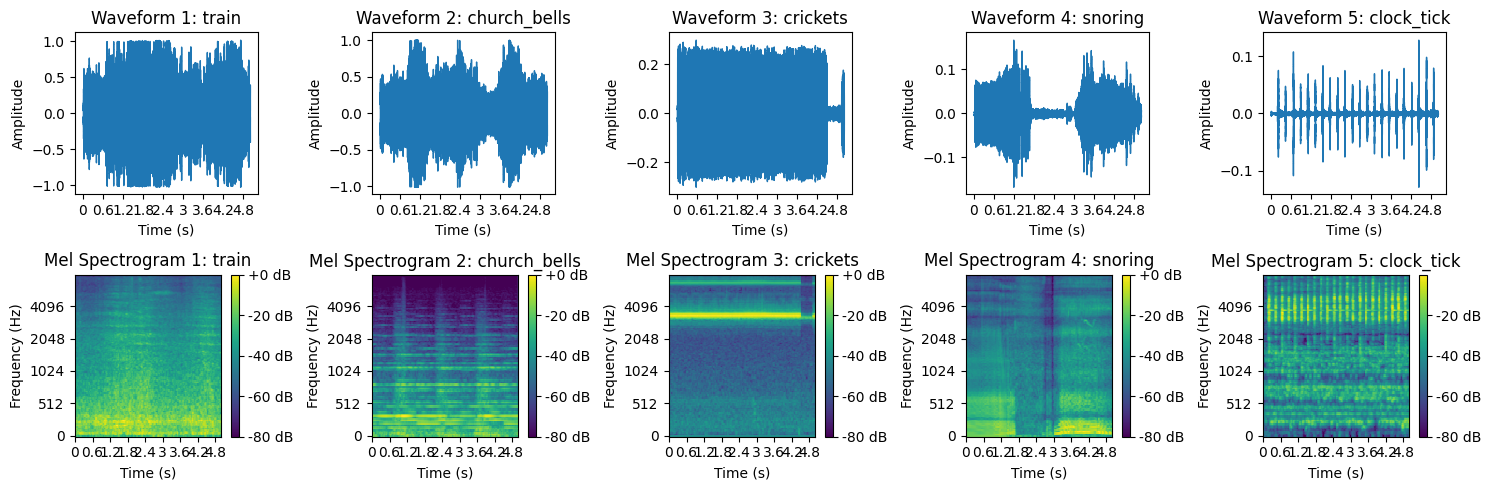

Audio Playback: ./ESC-50/ESC-50-master/audio/5-198600-A-45.wav (Label: train)


Audio Playback: ./ESC-50/ESC-50-master/audio/5-198373-A-46.wav (Label: church_bells)


Audio Playback: ./ESC-50/ESC-50-master/audio/5-204352-A-13.wav (Label: crickets)


Audio Playback: ./ESC-50/ESC-50-master/audio/2-52001-B-28.wav (Label: snoring)


Audio Playback: ./ESC-50/ESC-50-master/audio/5-209698-A-38.wav (Label: clock_tick)


In [70]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Audio, display

# プロット関数
def plot_audio_and_spectrograms(file_paths_with_labels, max_columns=5):
    num_files = len(file_paths_with_labels)
    num_rows = (num_files + max_columns - 1) // max_columns

    plt.figure(figsize=(15, 5 * num_rows))

    for idx, (file_path, label) in enumerate(file_paths_with_labels):
        # 音声データの読み込み
        y, sr = librosa.load(file_path, sr=16000)  # サンプリングレートを16kHzに指定

        # スペクトログラムの計算
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # プロット位置の計算
        row = idx // max_columns
        col = idx % max_columns

        # 波形プロット
        plt.subplot(num_rows * 2, max_columns, row * max_columns * 2 + col + 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Waveform {idx + 1}: {label}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # スペクトログラムプロット
        plt.subplot(num_rows * 2, max_columns, row * max_columns * 2 + max_columns + col + 1)
        librosa.display.specshow(log_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis")
        plt.title(f"Mel Spectrogram {idx + 1}: {label}")
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

    # 音声の再生
    for file_path, label in file_paths_with_labels:
        print(f"Audio Playback: {file_path} (Label: {label})")
        y, sr = librosa.load(file_path, sr=16000)
        display(Audio(y, rate=sr))

print("選ばれた音声ファイル:")
for idx, (file_path, label) in enumerate(selected_files_with_labels, 1):
    print(f"{idx}: {file_path} (Label: {label})")

plot_audio_and_spectrograms(selected_files_with_labels)


In [71]:
# 推論
for idx, (file_path, label) in enumerate(selected_files_with_labels, 1):
    print(f"{idx}: {file_path} (Label: {label})")
    print(f"推論結果: {predict_audio(file_path)}")


1: ./ESC-50/ESC-50-master/audio/5-198600-A-45.wav (Label: train)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
推論結果: 0
2: ./ESC-50/ESC-50-master/audio/5-198373-A-46.wav (Label: church_bells)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
推論結果: 0
3: ./ESC-50/ESC-50-master/audio/5-204352-A-13.wav (Label: crickets)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
推論結果: 0
4: ./ESC-50/ESC-50-master/audio/2-52001-B-28.wav (Label: snoring)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
推論結果: 0
5: ./ESC-50/ESC-50-master/audio/5-209698-A-38.wav (Label: clock_tick)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
推論結果: 0


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


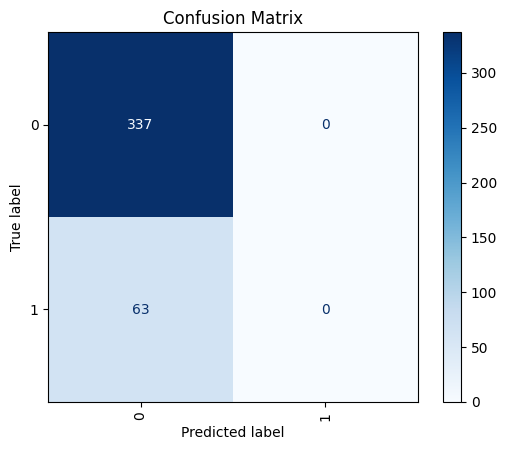

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 予測ラベルの取得
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 混同行列の計算
cm = confusion_matrix(y_test_enc, y_pred_classes, labels=range(len(encoder.classes_)))

# 混同行列の表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
